# Comparing fluxes with other products




In [1]:
import datetime
import numpy as np
import xarray as xr
import rioxarray as rxr
import pyproj

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
var = 'NEE'
var_fc = 'nee'
results_name = 'NEE_2003_2021_5km_LGBM_20221123.nc'
# upper = 'NEE_2003_2021_5km_LGBM_quantiles.nc'

## Open various datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

# ds_upper = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+upper)
# ds_upper.attrs['nodata'] = np.nan

# ds_lower = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+lower)
# ds_lower.attrs['nodata'] = np.nan

In [ ]:
# mask = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
# mask = mask[['FPAR']].to_array().isnull().all('variable')
# mask = mask.isel(time=1)

# ds = ds.where(~mask)
# ds_upper = ds_upper.where(~mask)

### Fluxcom

In [4]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs.nc'), crs='epsg:4326')
# ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

ds_fc_met = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
ds_fc_met = ds_fc_met.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc_met.attrs['nodata'] = np.nan
ds_fc_met['latitude'] = ds_fc_met.latitude.astype('float32')
ds_fc_met['longitude'] = ds_fc_met.longitude.astype('float32')


In [5]:
ds_fc['time'] = ds.sel(time=slice('2003', '2015')).time
ds_fc_met['time'] = ds.sel(time=slice('2003', '2018')).time

### CABLE

<!-- '/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019.nc' -->

In [6]:
cable_nee = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_nbp_25km_monthly_2003_2019.nc')
cable_nee_pop = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_nbp_100km_monthly_2003_2020.nc')
# cable_nee = cable_nee.sel(time=slice('2003', '2015'))

In [ ]:
cable_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_gpp_25km_monthly_2003_2019.nc')#.sel(time=slice('2003', '2015'))
cable_gpp_pop = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_gpp_100km_monthly_2003_2020.nc')
cable_gpp_pop = cable_gpp_pop['gpp']

### Fire emissions GFASv12

In [7]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

### MODIS GPP

In [ ]:
modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
modis_gpp.attrs['nodata'] = np.nan

### GOSIF GPP

In [ ]:
gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
gosif_gpp.attrs['nodata'] = np.nan

In [ ]:
# evi=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc')

### Villalobos et al 

Needed to fix the dataset before it could be opened. Used the R script in data/villalobos/

In [8]:
fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/post.tif'
post = rxr.open_rasterio(fn).rename({'band':'month'})
post['month']=ds.sel(time=slice('2015', '2019')).time.values
post = post.rename({'month':'time'})
#post = xr_reproject(post, geobox=post.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
post.attrs['nodata'] = np.nan
post.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/land.tif'
cable = rxr.open_rasterio(fn).rename({'band':'month'})
cable['month']=ds.sel(time=slice('2015', '2019')).time.values
cable = cable.rename({'month':'time'})
#cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
cable.attrs['nodata'] = np.nan
cable.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/fossil.tif'
ff = rxr.open_rasterio(fn).rename({'band':'month'})
ff['month']=ds.sel(time=slice('2015', '2019')).time.values
ff = ff.rename({'month':'time'})
#ff = xr_reproject(ff, geobox=ff.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
ff.attrs['nodata'] = np.nan
ff.attrs['units'] = 'PgC/year'

#subtract fossile fuels from inversion
post = post - ff

# create a mask for this janky dataset
mask_inv = cable.where(cable==0).isel(time=1)
mask_inv = mask_inv.astype(bool)

post = post.where(mask_inv)
cable = cable.where(mask_inv)

## Define a common grid

Resolution is similar to Villalobos as that's the coarest product

In [ ]:
# grid = zoom_out(ds.odc.geobox, 20)
# grid = grid.to_crs('EPSG:3577')
# grid

### Reproject datasets to match common grid

In [9]:
ds = xr_reproject(ds, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
# ds_upper = xr_reproject(ds_upper, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

In [10]:
ds_fc = xr_reproject(ds_fc, geobox=ds_fc.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc = ds_fc[var] #.where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

ds_fc_met = xr_reproject(ds_fc_met, geobox=ds_fc_met.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc_met = ds_fc_met[var] #.where(~mask.astype(bool))
ds_fc_met = ds_fc_met*30 #/day to /month

In [11]:
cable_nee = assign_crs(cable_nee, crs='epsg:4326')
cable_nee = xr_reproject(cable_nee, geobox=cable_nee.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']
#cable_nee = cable_nee.where(~mask.astype(bool))

cable_nee_pop = assign_crs(cable_nee_pop['nbp'], crs='epsg:4326')
cable_nee_pop = xr_reproject(cable_nee_pop, geobox=cable_nee_pop.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']
#cable_nee_pop = cable_nee_pop.where(~mask.astype(bool))

In [ ]:
cable_gpp = xr_reproject(assign_crs(cable_gpp, crs='epsg:4326'), geobox=cable_gpp.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

cable_gpp_pop = assign_crs(cable_gpp_pop, crs='epsg:4326')
cable_gpp_pop = xr_reproject(cable_gpp_pop, geobox=cable_gpp_pop.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') 

In [ ]:
grid = zoom_out(ds.odc.geobox, 5)
grid = grid.to_crs('EPSG:3577')
modis_gpp = xr_reproject(modis_gpp, geobox=grid.compat, resampling='average')

# modis_gpp = modis_gpp.where(~mask.astype(bool))

In [ ]:
gosif_gpp = xr_reproject(gosif_gpp, geobox=gosif_gpp.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

# gosif_gpp = gosif_gpp.where(~mask.astype(bool))

In [ ]:
# evi=xr_reproject(evi, geobox=grid.geobox, resampling='average')
# evi=evi.where(~mask.astype(bool))gosid

## Convert to total C in (petagrams) rather than gC/m2

Find area of pixels

In [12]:
ds = ds * ds.geobox.resolution[1]**2 * 1e-15 *12

# ds_upper = ds_upper * ds_upper.geobox.resolution[1]**2 * 1e-15 *12

ds_fc = ds_fc * ds_fc.geobox.resolution[1]**2 * 1e-15 * 12
ds_fc_met = ds_fc_met * ds_fc_met.geobox.resolution[1]**2 * 1e-15 * 12

cable_nee = cable_nee * cable_nee.geobox.resolution[1]**2 * 1e-15 *12
cable_nee_pop = cable_nee_pop * cable_nee_pop.geobox.resolution[1]**2 * 1e-15 *12

# cable_gpp = cable_gpp * cable_gpp.geobox.resolution[1]**2 * 1e-15
# cable_gpp = cable_gpp*12

# cable_gpp_pop = cable_gpp_pop * cable_gpp_pop.geobox.resolution[1]**2 * 1e-15
# cable_gpp_pop = cable_gpp_pop*12

In [ ]:
modis_gpp = modis_gpp * modis_gpp.geobox.resolution[1]**2 * 1e-12
modis_gpp = modis_gpp*12
gosif_gpp = gosif_gpp * gosif_gpp.geobox.resolution[1]**2 * 1e-15
gosif_gpp = gosif_gpp*12

## Export harmonized dataset

In [ ]:
# merged = xr.merge([
#     ds_fc.rename('Fluxcom_RS_GPP'),
#     ds_fc_met.rename('Fluxcom_RS-meteo_GPP'),#,.sel(time=slice('2003', '2015')),
#     ds.rename('ThisStudy_GPP'),#.sel(time=slice('2003', '2015')),
#     cable_gpp.rename('Cable_GPP'),#.sel(time=slice('2003', '2015')),
#     modis_gpp.rename('MODIS_GPP'),#.sel(time=slice('2003', '2015')),
#     gosif_gpp.rename('GOSIF_GPP'),#.sel(time=slice('2003', '2015'))
# ])

# # merged = xr.merge([
# #     ds_fc_met.rename('Fluxcom_RS-Meteo_NEE'),
# #     ds_fc.rename('Fluxcom_RS_NEE'),#.sel(time=slice('2003', '2015')),
# #     ds.rename('ThisStudy_NEE'),#.sel(time=slice('2003', '2015')),
# #     cable_nee.rename('Cable_NEE')#.sel(time=slice('2003', '2015')),
# # ])

# merged.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/harmonized_gpp.nc')

## Plot time-series and find annual mean and std dev 

In [ ]:
# mask = xr.where(ds==0, 0, 1)
# ds = ds.where(mask)
# ds.isel(time=1).plot.imshow()

In [30]:
trim=True

In [31]:
if trim:
    trim_date = '2003','2015'
    ds = ds.sel(time=slice(trim_date[0], trim_date[1]))
    # ds_upper = ds_upper.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc = ds_fc.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc_met = ds_fc_met.sel(time=slice(trim_date[0], trim_date[1]))
    cable_nee = cable_nee.sel(time=slice(trim_date[0], trim_date[1]))
    cable_nee_pop = cable_nee_pop.sel(time=slice(trim_date[0], trim_date[1]))
    # cable_gpp = cable_gpp.sel(time=slice('2003', '2019'))
    # cable_gpp_pop = cable_gpp_pop.sel(time=slice('2003', '2019'))
    # modis_gpp = modis_gpp.sel(time=slice('2003', '2019'))
    # gosif_gpp = gosif_gpp.sel(time=slice('2003', '2019'))

In [13]:
ds_1d = ds.sum(['x', 'y'])
# ds_1d_upper = ds_upper.sum(['x', 'y'])

ds_fc_1d = ds_fc.sum(['x', 'y'])
ds_fc_met_1d = ds_fc_met.sum(['x', 'y'])

post_1d = post.sum(['x', 'y'])
cable_nee_1d = cable_nee.sum(['x', 'y'])
cable_nee_pop_1d = cable_nee_pop.sum(['x', 'y'])

# cable_gpp_pop_1d = cable_gpp_pop.sum(['x', 'y'])
# cable_gpp_1d = cable_gpp.sum(['x', 'y'])

# gosif_gpp_1d = gosif_gpp.sum(['x', 'y'])
# modis_gpp_1d = modis_gpp.sum(['x', 'y'])

In [14]:
print(f'Mean of this study: {ds_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of this study: {ds_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Fluxcom-RS: {ds_fc_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Fluxcom-met: {ds_fc_met_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Fluxcom-met: {ds_fc_met_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Inversion: {post_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Inversion: {post_1d.std().values:.3f} PgC/yr')
print('\n')
# print(f'Mean of Cable: {cable_1d.mean().values:.3f} PgC/yr')
# print(f'Std Dev of Cable: {cable_1d.std().values:.3f} PgC/yr')
print(f'Mean of Cable-BIOS: {cable_nee_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Cable-BIOS: {cable_nee_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Cable-POP: {cable_nee_pop_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Cable-POP: {cable_nee_pop_1d.std().values:.3f} PgC/yr')

Mean of this study: -0.329 PgC/yr
Std Dev of this study: 0.424 PgC/yr


Mean of Fluxcom-RS: -0.064 PgC/yr
Std Dev of Fluxcom-RS: 0.248 PgC/yr


Mean of Fluxcom-met: -0.235 PgC/yr
Std Dev of Fluxcom-met: 0.340 PgC/yr


Mean of Inversion: -0.465 PgC/yr
Std Dev of Inversion: 0.960 PgC/yr


Mean of Cable-BIOS: -0.137 PgC/yr
Std Dev of Cable-BIOS: 0.407 PgC/yr


Mean of Cable-POP: -0.026 PgC/yr
Std Dev of Cable-POP: 0.512 PgC/yr


In [16]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 15})

### Plot time-series of NEE w/o rolling mean

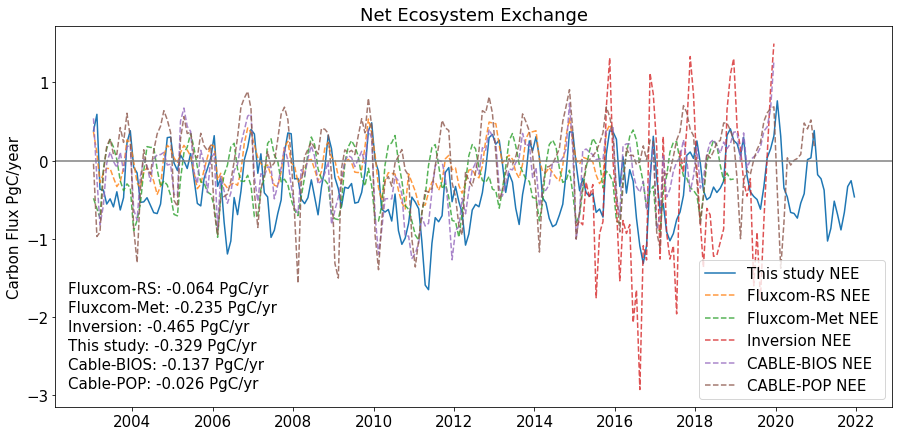

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d,  label='This study '+var)
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d, linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d, linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)

ax.plot(post_1d.time.values, post_1d, linestyle='--', label='Inversion '+var, alpha=0.8)
ax.plot(cable_nee_1d.time.values, cable_nee_1d, linestyle='--', label='CABLE-BIOS '+var, alpha=0.8)
ax.plot(cable_nee_pop_1d.time.values, cable_nee_pop_1d, linestyle='--', label='CABLE-POP '+var, alpha=0.8)

plt.axhline(0, c='grey')
ax.legend(loc='lower right')
ax.set_ylabel('Carbon Flux PgC/year');
ax.text(.015, .30, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .25, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .20, f'Inversion: {post_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .15, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .10, f'Cable-BIOS: {cable_nee_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .05, f'Cable-POP: {cable_nee_pop_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

plt.title('Net Ecosystem Exchange');
# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2019, 12, 31)])
# ax.set_ylim(-2.5, 2.5)


### Plot timeseries of NEE with rolling mean

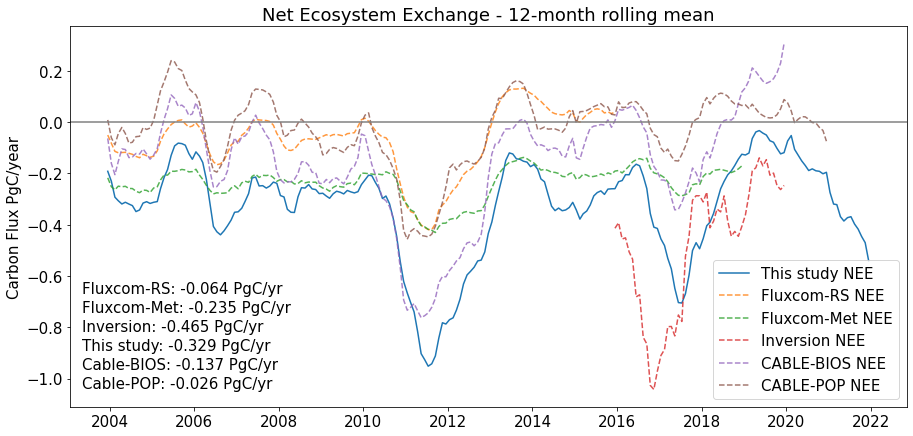

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d.rolling(time=12, min_periods=12).mean(),  label='This study '+var)
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)
ax.plot(post_1d.time.values, post_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Inversion '+var, alpha=0.8)
ax.plot(cable_nee_1d.time.values, cable_nee_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='CABLE-BIOS '+var, alpha=0.8)
ax.plot(cable_nee_pop_1d.time.values, cable_nee_pop_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='CABLE-POP '+var, alpha=0.8)

plt.axhline(0, c='grey')
ax.legend(loc='lower right')
ax.set_ylabel('Carbon Flux PgC/year');
ax.text(.015, .30, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .25, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .20, f'Inversion: {post_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .15, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .10, f'Cable-BIOS: {cable_nee_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .05, f'Cable-POP: {cable_nee_pop_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

plt.title('Net Ecosystem Exchange - 12-month rolling mean');
# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2019, 12, 31)])
# ax.set_ylim(-2.5, 2.5)

### Plot timeseries of GPP w/o rolling mean

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d,  label='This study '+var)
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d, linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d, linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)
ax.plot(modis_gpp_1d.time.values, modis_gpp_1d, linestyle='--', label='MODIS '+var, alpha=0.75)
ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(cable_gpp_1d.time.values, cable_gpp_1d, linestyle='--', label='CABLE-BIOS '+var, alpha=0.8)
ax.plot(cable_gpp_pop_1d.time.values, cable_gpp_pop_1d, linestyle='--', label='CABLE-POP '+var, alpha=0.8)


# plt.axhline(0, c='grey')
ax.legend(loc='upper right')
ax.set_ylabel('Carbon Flux PgC/year');
ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .70, f'Cable-BIOS: {cable_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .65, f'Cable-POP: {cable_gpp_pop_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

plt.title('Gross Primary Productivity');
# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2019, 12, 31)])
# ax.set_ylim(-2.5, 2.5)


### plot timeseries of GPP with rolling mean

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d.rolling(time=12, min_periods=12).mean(),  label='This study '+var)
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)
ax.plot(modis_gpp_1d.time.values, modis_gpp_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='MODIS '+var, alpha=0.75)
ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(cable_gpp_1d.time.values, cable_gpp_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='CABLE-BIOS '+var, alpha=0.8)
ax.plot(cable_gpp_pop_1d.time.values, cable_gpp_pop_1d.rolling(time=12, min_periods=12).mean(), linestyle='--', label='CABLE-POP '+var, alpha=0.8)


# plt.axhline(0, c='grey')
ax.legend(loc='upper right')
ax.set_ylabel('Carbon Flux PgC/year');
ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);

ax.text(.015, .70, f'Cable-BIOS: {cable_gpp_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

ax.text(.015, .65, f'Cable-POP: {cable_gpp_pop_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)

plt.title('Gross Primary Productivity');
# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2019, 12, 31)])
# ax.set_ylim(-2.5, 2.5)

## Annual means and variance

In [ ]:
# annual_mean = ds.groupby('time.year').sum().mean('year')
# annual_mean_fc = ds_fc.groupby('time.year').sum().mean('year')
# annual_mean_post = post.groupby('time.year').sum().mean('year')
# annual_mean_cable = cable_nee.groupby('time.year').sum().mean('year')

# annual_std = ds.groupby('time.year').sum().std('year')
# annual_std_fc = ds_fc.groupby('time.year').sum().std('year')
# annual_std_post = post.groupby('time.year').sum().std('year')
# annual_std_cable = cable_nee.groupby('time.year').sum().std('year')

# scaled_variance = annual_std / annual_mean
# scaled_variance_fc = annual_std_fc / annual_mean_fc
# scaled_variance_post = annual_std_post / annual_mean_post
# scaled_variance_cable = annual_std_cable / annual_mean_cable

In [ ]:

# fig,ax = plt.subplots(3,2, figsize=(15,19),sharey=True, sharex=True)
# im = annual_mean.plot.imshow(ax=ax[0,0], vmax=0.01,cbar_kwargs={'shrink':0.7}, add_labels=False)  #cmap='RdBu_r'
# # annual_std.where(annual_std>0).plot.imshow(ax=ax[0,1], cmap='magma', vmax=0.01)
# np.absolute(scaled_variance).plot.imshow(ax=ax[0,1], cmap='magma', vmax=3, cbar_kwargs={'shrink':0.7}, add_labels=False)
# # ax[0,0].set_title('Annual Mean of '+var+')
# # ax[0].set_title('Annual Mean of '+var+', 2003-2021')
# # ax[0].set_title('Annual Mean of '+var+', 2003-2021')

# im = annual_mean_fc.plot.imshow(ax=ax[1,0], vmax=0.01,cbar_kwargs={'shrink':0.7}, add_labels=False)  #cmap='RdBu_r'
# # annual_std_fc.where(annual_std_fc>0).plot.imshow(ax=ax[1,1], cmap='magma', vmax=0.01)
# np.absolute(scaled_variance_fc).plot.imshow(ax=ax[1,1], cmap='magma', vmax=3, cbar_kwargs={'shrink':0.7}, add_labels=False)

# im = annual_mean_cable.plot.imshow(ax=ax[2,0], vmax=0.01,cbar_kwargs={'shrink':0.7}, add_labels=False)  #cmap='RdBu_r'
# # annual_std_cable.where(annual_std_cable>0).plot.imshow(ax=ax[2,1], cmap='magma', vmax=0.01)
# im1 = np.absolute(scaled_variance_cable).plot.imshow(ax=ax[2,1], cmap='magma', vmax=3, cbar_kwargs={'shrink':0.7}, add_labels=False)

# # annual_mean_post.plot.imshow(ax=ax[3,0], robust=True)  #cmap='RdBu_r'
# # annual_std_post.where(annual_std_post>0).plot.imshow(ax=ax[3,1], cmap='magma', vmax=0.015)
# # np.absolute(scaled_variance_post).plot.imshow(ax=ax[3,2], cmap='magma', vmax=2)

# ax[0,0].set_title('This Study')
# ax[0,1].set_title('This Study')
# ax[1,0].set_title('Fluxcom')
# ax[1,1].set_title('Fluxcom')
# ax[2,0].set_title('CABLE-POP')
# ax[2,1].set_title('CABLE-POP')
# # fig.subplots_adjust(hspace=0.1)
# # cbar_ax = fig.add_axes([0.0575, 0.1, .35, .015]) #left, bottom, width, height
# # cbar1_ax = fig.add_axes([0.575, 0.1, .35, .015]) #left, bottom, width, height
# # cbar = fig.colorbar(im, spacing='uniform', ax=ax[2][0], orientation='vertical', shrink=0.7, label='Annual Mean, PgC/year')
# # cbar1 = fig.colorbar(im1, spacing='uniform', ax=ax[2][1], orientation='vertical', shrink=0.7, label='Coefficient of Variation')
# # cbar1 = fig.colorbar(im1, spacing='uniform', ax=ax.ravel().tolist(), orientation='horizontal', shrink=0.4)

# ax[0,0].set_xticks([])
# ax[0,1].set_yticks([])
# ax[1,0].set_xticks([])
# ax[1,1].set_yticks([])
# ax[2,0].set_xticks([])
# ax[2,1].set_yticks([])
# plt.tight_layout();
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/annual_mean_variance.png')

## Convert to anomalies

### Climatology

In [34]:
import warnings
warnings.filterwarnings("ignore")

ds_clim_mean = ds.groupby('time.month').mean()
ds_clim_mean_annual = ds.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

# ds_upper_clim_mean = ds_upper.groupby('time.month').mean()
# ds_upper_clim_mean_annual = ds_upper.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

# ds_lower_clim_mean = ds_lower.groupby('time.month').mean()
# ds_lower_clim_mean_annual = ds_lower.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

ds_fc_clim_mean = ds_fc.groupby('time.month').mean()
ds_fc_clim_mean_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

ds_fc_met_clim_mean = ds_fc_met.groupby('time.month').mean()
ds_fc_met_clim_mean_annual = ds_fc_met.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

post_clim_mean = post.groupby('time.month').mean()
post_clim_mean_annual = post.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

cable_nee_clim_mean = cable_nee.groupby('time.month').mean()
cable_nee_clim_mean_annual = cable_nee.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

cable_nee_pop_clim_mean = cable_nee_pop.groupby('time.month').mean()
cable_nee_pop_clim_mean_annual = cable_nee_pop.resample(time='1Y', label='left', loffset='6M').sum().mean('time')


In [ ]:
cable_gpp_clim_mean = cable_gpp.groupby('time.month').mean()
cable_gpp_clim_mean_annual = cable_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

cable_gpp_pop_clim_mean = cable_gpp_pop.groupby('time.month').mean()
cable_gpp_pop_clim_mean_annual = cable_gpp_pop.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

modis_gpp_clim_mean = modis_gpp.groupby('time.month').mean()
modis_gpp_clim_mean_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

gosif_gpp_clim_mean = gosif_gpp.groupby('time.month').mean()
gosif_gpp_clim_mean_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

### Anomalies

In [20]:
ds_anom = (ds.groupby('time.month') - ds_clim_mean)
# ds_upper_anom = (ds_upper.groupby('time.month') - ds_clim_mean) 
# ds_lower_anom = (ds_lower.groupby('time.month') - ds_clim_mean)
ds_fc_anom = (ds_fc.groupby('time.month') - ds_fc_clim_mean)
ds_fc_met_anom = (ds_fc_met.groupby('time.month') - ds_fc_met_clim_mean)
post_anom = (post.groupby('time.month') - post_clim_mean)
cable_nee_anom = (cable_nee.groupby('time.month') - cable_nee_clim_mean)
cable_nee_pop_anom = (cable_nee_pop.groupby('time.month') - cable_nee_pop_clim_mean)

# ds_anom_annual = ds.resample(time='1Y', label='left', loffset='6M').sum() - ds_clim_mean_annual
# ds_fc_anom_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum() - ds_fc_clim_mean_annual
# # post_anom_annual = post.resample(time='1Y', label='left', loffset='6M').sum() - post_clim_mean_annual
# # cable_anom_annual = cable.resample(time='1Y', label='left', loffset='6M').sum() - cable_clim_mean_annual
# cable_nee_anom_annual = cable_nee.resample(time='1Y', label='left', loffset='6M').sum() - cable_nee_clim_mean_annual



In [ ]:
cable_gpp_anom = (cable_gpp.groupby('time.month') - cable_gpp_clim_mean)
cable_gpp_pop_anom = (cable_gpp_pop.groupby('time.month') - cable_gpp_pop_clim_mean)

modis_gpp_anom = (modis_gpp.groupby('time.month') - modis_gpp_clim_mean)
gosif_gpp_anom = (gosif_gpp.groupby('time.month') - gosif_gpp_clim_mean)

modis_gpp_anom_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum() - modis_gpp_clim_mean_annual
gosif_gpp_anom_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum() - gosif_gpp_clim_mean_annual

## Zonal summaries

### Monthly

In [21]:
ds_1D = ds_anom.sum(['x','y'])
# ds_upper_1D = ds_upper_anom.sum(['x','y'])
# ds_lower_1D = ds_lower_anom.sum(['x','y'])
ds_fc_1D = ds_fc_anom.sum(['x','y'])
ds_fc_met_1D = ds_fc_met_anom.sum(['x','y'])

post_1D = post_anom.sum(['x','y'])
cable_nee_1D = cable_nee_anom.sum(['x','y'])
cable_nee_pop_1D = cable_nee_pop_anom.sum(['x','y'])

# cable_gpp_1D = cable_gpp_anom.sum(['x','y'])
# cable_gpp_pop_1D = cable_gpp_pop_anom.sum(['x','y'])

In [ ]:
modis_gpp_1D = modis_gpp_anom.sum(['x','y'])
gosif_gpp_1D = gosif_gpp_anom.sum(['x','y'])

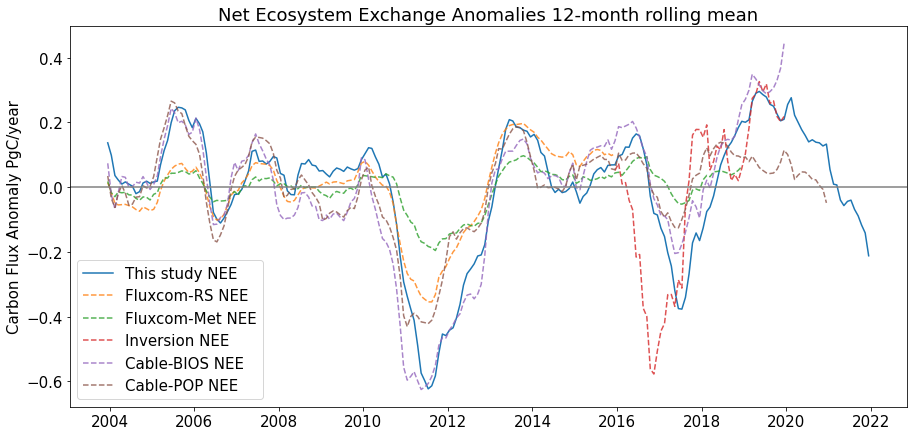

In [23]:
# if trim:
#     ds = ds.sel(time=slice('2015', '2019'))
#     ds_fc = ds.sel(time=slice('2015', '2019'))

fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.plot(ds_1D.time.values, ds_1D.rolling(time=12, min_periods=12).mean(), label='This study '+var)
# ax.fill_between(ds_1D.time.values,
#                 ds_upper_1D.rolling(time=3, min_periods=1).mean(),
#                 ds_lower_1D.rolling(time=3, min_periods=1).mean(),
#                 alpha=0.2)

ax.plot(ds_fc_1D.time.values, ds_fc_1D.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1D.time.values, ds_fc_met_1D.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)

ax.plot(post_1D.time.values, post_1D.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Inversion '+var, alpha=0.8)

ax.plot(cable_nee_1D.time.values, cable_nee_1D.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Cable-BIOS '+var, alpha=0.8)
ax.plot(cable_nee_pop_1D.time.values, cable_nee_pop_1D.rolling(time=12, min_periods=12).mean(), linestyle='--', label='Cable-POP '+var, alpha=0.8)


ax.legend(loc='lower left')
ax.set_ylabel('Carbon Flux Anomaly PgC/year');

# ax.set_ylim(-0.175, 0.175)
# ax.text(.015, .95, f'Fluxcom: {ds_fc_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .90, f'Inversion: {post_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .85, f'Cable: {cable_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .80, f'This study: {ds_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes);
# ax2=ax.twinx()
# # ax2.plot(evi_1D.time.values, evi_1D, label='MODIS-EVI', color='c', )
# ax2.legend(loc='upper right')
# ax2.set_ylim(-0.05, 0.05)
# ax2.set_ylabel('EVI Anomaly');

plt.axhline(0, c='grey');
plt.title('Net Ecosystem Exchange Anomalies 12-month rolling mean');



In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.plot(ds_1D.time.values, ds_1D, label='This study '+var)
# ax.fill_between(ds_1D.time.values,
#                 ds_upper_1D.rolling(time=3, min_periods=1).mean(),
#                 ds_lower_1D.rolling(time=3, min_periods=1).mean(),
#                 alpha=0.2)

ax.plot(ds_fc_1D.time.values, ds_fc_1D, linestyle='--', label='Fluxcom-RS '+var, alpha=0.8)
ax.plot(ds_fc_met_1D.time.values, ds_fc_met_1D, linestyle='--', label='Fluxcom-Met '+var, alpha=0.8)

ax.plot(modis_gpp_1D.time.values, modis_gpp_1D, linestyle='--', label='MODIS '+var, alpha=0.75)
ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D, linestyle='--', label='GOSIF '+var, alpha=0.75)

ax.plot(cable_gpp_1D.time.values, cable_gpp_1D, linestyle='--', label='Cable-BIOS '+var, alpha=0.8)
ax.plot(cable_gpp_pop_1D.time.values, cable_gpp_pop_1D, linestyle='--', label='Cable-POP '+var, alpha=0.8)

ax.legend(loc='upper left')
ax.set_ylabel('Carbon Flux Anomaly PgC/year');

# ax.set_ylim(-0.175, 0.175)
# ax.text(.015, .95, f'Fluxcom: {ds_fc_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .90, f'Inversion: {post_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .85, f'Cable: {cable_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .80, f'This study: {ds_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes);
# ax2=ax.twinx()
# # ax2.plot(evi_1D.time.values, evi_1D, label='MODIS-EVI', color='c', )
# ax2.legend(loc='upper right')
# ax2.set_ylim(-0.05, 0.05)
# ax2.set_ylabel('EVI Anomaly');
plt.axhline(0, c='grey');
plt.title('Gross Primary Productivity');


## Month of maximum flux

In [25]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 12})

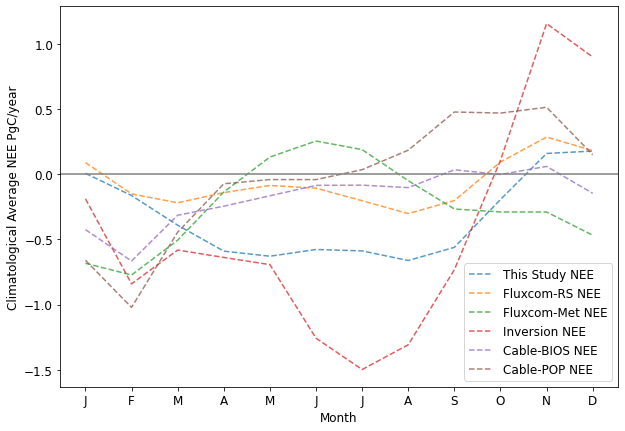

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

y = ds_clim_mean.sum(['x','y']).values
x = ds_clim_mean.month.values

y_fc = ds_fc_clim_mean.sum(['x','y']).values
x_fc = ds_fc_clim_mean.month.values

y_fc_met = ds_fc_met_clim_mean.sum(['x','y']).values
x_fc_met = ds_fc_met_clim_mean.month.values

y_post = post_clim_mean.sum(['x','y']).values
x_post = post_clim_mean.month.values

y_cable_nee = cable_nee_clim_mean.sum(['x','y']).values
x_cable_nee = cable_nee_clim_mean.month.values

y_cable_nee_pop = cable_nee_pop_clim_mean.sum(['x','y']).values
x_cable_nee_pop = cable_nee_pop_clim_mean.month.values

# y_modis_gpp = modis_gpp_clim_mean.sum(['x','y']).values
# x_modis_gpp = modis_gpp_clim_mean.month.values

# y_gosif_gpp = gosif_gpp_clim_mean.sum(['x','y']).values
# x_gosif_gpp = gosif_gpp_clim_mean.month.values

# y_cable_gpp = cable_gpp_clim_mean.sum(['x','y']).values
# x_cable_gpp = cable_gpp_clim_mean.month.values

# y_cable_gpp_pop = cable_gpp_pop_clim_mean.sum(['x','y']).values
# x_cable_gpp_pop = cable_gpp_pop_clim_mean.month.values

ax.plot(x, y, linestyle='--', label='This Study '+var, alpha=0.75)
ax.plot(x_fc, y_fc, linestyle='--', label='Fluxcom-RS '+var, alpha=0.75)
ax.plot(x_fc_met, y_fc_met, linestyle='--', label='Fluxcom-Met '+var, alpha=0.75)
ax.plot(x_post, y_post, linestyle='--', label='Inversion '+var, alpha=0.75)
ax.plot(x_cable_nee, y_cable_nee, linestyle='--', label='Cable-BIOS '+var, alpha=0.75)
ax.plot(x_cable_nee_pop, y_cable_nee_pop, linestyle='--', label='Cable-POP '+var, alpha=0.75)

# ax.plot(x_modis_gpp, y_modis_gpp,  linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(x_gosif_gpp, y_gosif_gpp,  linestyle='--', label='GOSIF '+var, alpha=0.75)
# ax.plot(x_cable_gpp, y_cable_gpp, linestyle='--', label='Cable-BIOS '+var, alpha=0.75)
# ax.plot(x_cable_gpp_pop, y_cable_gpp_pop, linestyle='--', label='Cable-POP '+var, alpha=0.75)


ax.axhline(0, c='grey')
ax.legend(loc='lower right')
# ax.set_title(var+' Climatology')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])             
ax.set_ylabel('Climatological Average '+var+' PgC/year');


In [36]:
if var == 'NEE':
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'min')
    max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'min')
    max_mean_month_post = allNaN_arg(post_clim_mean, 'month', 'min')
    #max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'min')
    max_mean_month_cable_nee = allNaN_arg(cable_nee_clim_mean, 'month', 'min')
    max_mean_month_cable_nee_pop = allNaN_arg(cable_nee_pop_clim_mean, 'month', 'min')
    # max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'min')
    # max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'min')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
    max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'max')
    max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'max')
    max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'max')
    max_mean_month_cable_gpp = allNaN_arg(cable_gpp_clim_mean, 'month', 'max')
    max_mean_month_cable_gpp_pop = allNaN_arg(cable_gpp_pop_clim_mean, 'month', 'max')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

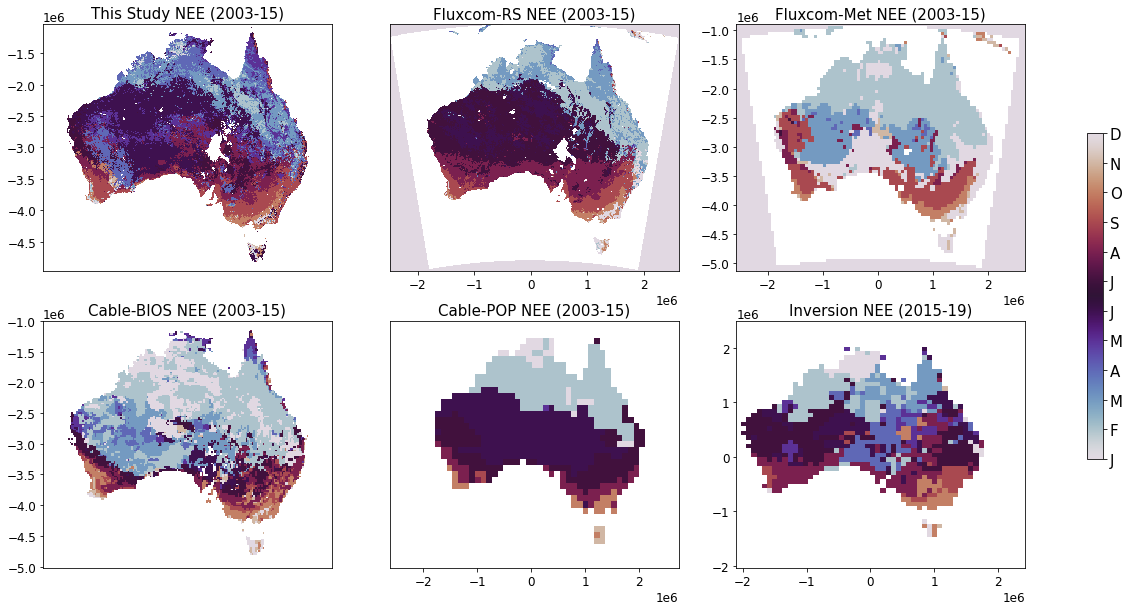

In [37]:
fig,ax = plt.subplots(2,3, figsize=(22,10))

y_range = ' (2003-15)'
font=15
im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,1].set_title('Fluxcom-RS '+var+y_range, fontsize=font);

im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,2].set_title('Fluxcom-Met '+var+y_range, fontsize=font);

im = max_mean_month_cable_nee.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

im = max_mean_month_cable_nee_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);

im = max_mean_month_post.isel(x=range(12, 68), y=range(12, 68)).plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False, add_labels=False)
ax[1,2].set_title('Inversion '+var+' (2015-19)', fontsize=font);

ax[0,0].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,1].set_yticks([])
cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='vertical', shrink=0.6)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=font)
# plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png')


In [ ]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 8})

In [ ]:
fig,ax = plt.subplots(2,4, figsize=(25,10), sharey=True, sharex=True)
fonts=15
im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,0].set_title('This Study '+var+' (2003-21)', fontsize=fonts);

im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,1].set_title('Fluxcom-RS '+var+' (2003-15)', fontsize=fonts);

im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,2].set_title('Fluxcom-Met '+var+' (2003-18)', fontsize=fonts);

im = max_mean_month_cable_gpp.plot.imshow(vmin=1, vmax=12, ax=ax[0,3], cmap='twilight', add_colorbar=False, add_labels=False)
ax[0,3].set_title('Cable-BIOS '+var+' (2003-19)', fontsize=fonts);

im = max_mean_month_cable_gpp_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
ax[1,0].set_title('Cable-POP '+var+' (2003-20)', fontsize=fonts);

im = max_mean_month_modis.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
ax[1,1].set_title('MODIS '+var+' (2003-21)', fontsize=fonts);

im = max_mean_month_gosif.plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False)
ax[1,2].set_title('GOSIF '+var+' (2003-21)', fontsize=fonts);

ax[0,0].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,1].set_yticks([])
cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='vertical', shrink=0.6)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
# plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png')